## **Fonte**

https://medium.com/swlh/multi-label-text-classification-with-scikit-learn-and-tensorflow-257f9ee30536

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
df_rotulados = pd.read_csv('dados/df_rotulados_spel_diac.csv', sep='|')
df_rotulados.drop(['LABELS'], axis=1, inplace=True)
print(df_rotulados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       330 non-null    object
 1   DECISAO  330 non-null    object
 2   1        330 non-null    int64 
 3   2        330 non-null    int64 
 4   3        330 non-null    int64 
 5   4        330 non-null    int64 
 6   5        330 non-null    int64 
 7   6        330 non-null    int64 
 8   7        330 non-null    int64 
 9   8        330 non-null    int64 
 10  9        330 non-null    int64 
 11  10       330 non-null    int64 
 12  11       330 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 33.6+ KB
None


In [3]:
def acordoas_categoria(title=''):

    categories = list(df_rotulados.columns.values)
    sns.set(font_scale = 2)
    plt.figure(figsize=(15,8))

    ax= sns.barplot(categories[2:], df_rotulados.iloc[:,2:].sum().values)
    plt.title(title, fontsize=24)
    plt.ylabel('Numero de acórdãos', fontsize=18)
    plt.xlabel('Tipo de acórdão ', fontsize=18)
    
    #adding the text labels
    rects = ax.patches
    labels = df_rotulados.iloc[:,2:].sum().values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=14)
    plt.show()

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


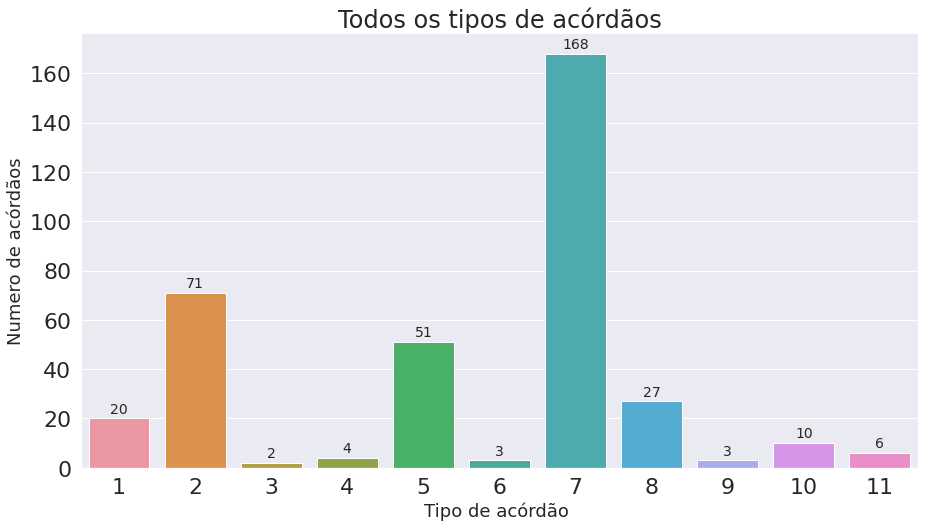

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


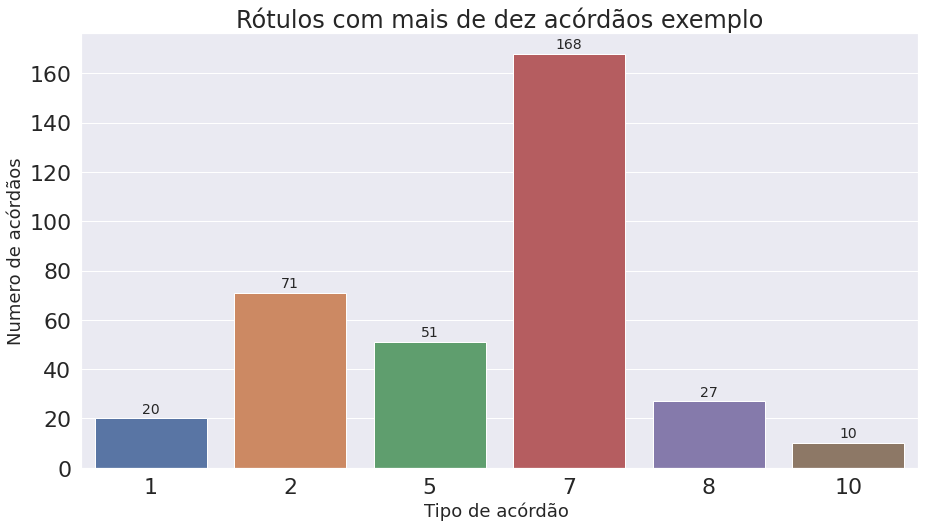

In [4]:
acordoas_categoria('Todos os tipos de acórdãos')

''' Remoção das classes com menos de 10 exemplos uma vez que isso interfere na hora de calcular a curva ROC, 
pois no momento do split dos dados para criação dos dataset de treino e teste não há registros suficientes para todas as classes
'''
df_rotulados.drop(['3','4','6','9', '11'],axis=1, inplace=True)

# Remoção das linhas que pelo motivo acima não possuem registros
df_rotulados.drop(df_rotulados.loc[(df_rotulados.iloc[:,2:].sum(axis=1))==0].index, axis=0, inplace=True)

acordoas_categoria('Rótulos com mais de dez acórdãos exemplo')

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


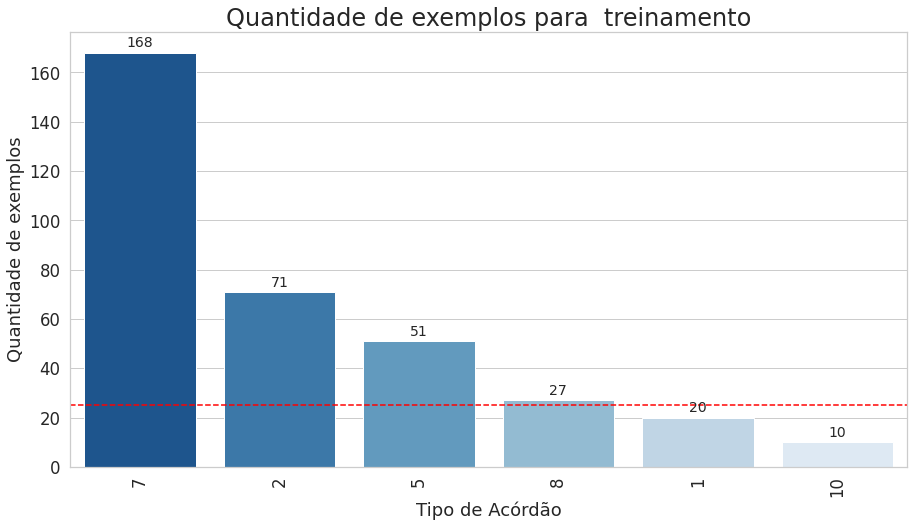

In [5]:
bar_plot = pd.DataFrame()
bar_plot['ACORDAOS'] = df_rotulados.columns[2:]
bar_plot['SOMA'] = df_rotulados.iloc[:,2:].sum().values
bar_plot.sort_values(['SOMA'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
# print(bar_plot)

threshold = 25

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['SOMA'].argsort().argsort()  

ax = sns.barplot(bar_plot['ACORDAOS'], bar_plot['SOMA'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Quantidade de exemplos para  treinamento", fontsize=24)
plt.ylabel('Quantidade de exemplos', fontsize=18)
plt.xlabel('Tipo de Acórdão', fontsize=18)
plt.xticks(rotation='vertical')

# adding the text labels
rects = ax.patches
labels = bar_plot.SOMA
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=14)
plt.show()

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


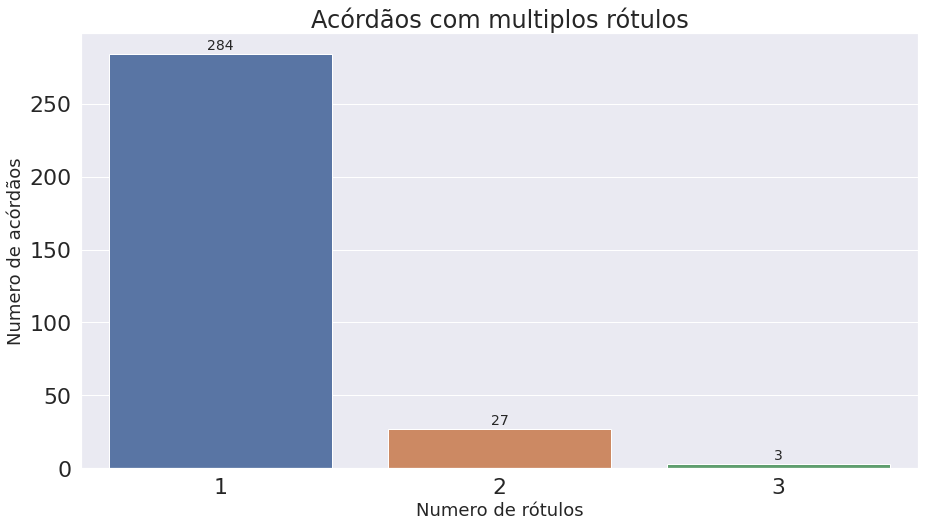

In [6]:
rowSums = df_rotulados.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Acórdãos com multiplos rótulos")
plt.ylabel('Numero de acórdãos', fontsize=18)
plt.xlabel('Numero de rótulos', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=14)
plt.show()

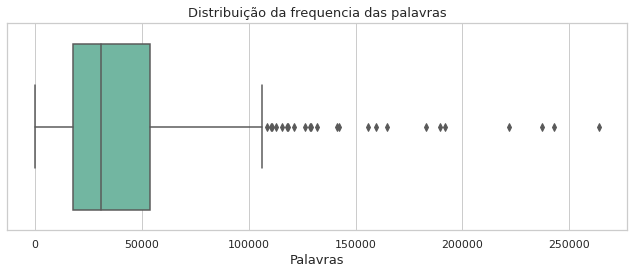

In [7]:
boxplot = df_rotulados.copy()
boxplot['len'] = df_rotulados.DECISAO.apply(lambda x: len(x))

sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})

plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Palavras')
plt.title("Distribuição da frequencia das palavras", fontsize=13)
plt.tight_layout(h_pad=3)

In [8]:
columns=['OneVsAll', 'BinaryRelevance', 'ClassifierChain', 'MultipleOutput']
results = pd.DataFrame(columns = columns)
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput


## **Formas de dividir o dataset em três partes**

train, validate, test = np.split(df_rotulados.sample(frac=1), [int(.6*len(df_rotulados)), int(.8*len(df_rotulados))])

x_train, x_test, y_train, y_test = train_test_split(df_rotulados.DECISAO, 
                                                    df_rotulados[df_rotulados.columns[2:]], 
                                                    test_size=0.2, 
                                                    random_state=1977, 
                                                    shuffle=True)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                    y_train,
                                                    test_size=0.25, 
                                                    random_state=1977, 
                                                    shuffle=True)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_rotulados.DECISAO, df_rotulados[df_rotulados.columns[2:]], 
                                                    test_size=0.3, 
                                                    random_state=1977,
                                                    shuffle=True)

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2')
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)

In [10]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])

accuracy = 0
for category in df_rotulados.columns[2:]:
    print('**Processando a classe {} dos acórdãos...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(x_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(x_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(df_rotulados.columns[1:])))

**Processando a classe 1 dos acórdãos...**
AUC ROC score is 0.5


**Processando a classe 2 dos acórdãos...**
AUC ROC score is 0.5227272727272727


**Processando a classe 5 dos acórdãos...**
AUC ROC score is 0.5


**Processando a classe 7 dos acórdãos...**
AUC ROC score is 0.671985815602837


**Processando a classe 8 dos acórdãos...**
AUC ROC score is 0.5


**Processando a classe 10 dos acórdãos...**
AUC ROC score is 0.5


Test averaged AUC ROC is 0.7263157894736842


In [11]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

accuracy = 0
for category in df_rotulados.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(x_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(x_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(df_rotulados.columns[1:])))

**Processing 1 titles...**
AUC ROC is 0.5


**Processing 2 titles...**
AUC ROC is 0.5


**Processing 5 titles...**
AUC ROC is 0.5


**Processing 7 titles...**
AUC ROC is 0.5108599290780141


**Processing 8 titles...**
AUC ROC is 0.5


**Processing 10 titles...**
AUC ROC is 0.5


Test averaged AUC ROC is 0.7022556390977444


In [12]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

accuracy = 0
for category in df_rotulados.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    SVC_pipeline.fit(x_train, y_train[category])
    
    # calculating test accuracy
    prediction = SVC_pipeline.predict(x_test)
    accuracy = accuracy + roc_auc_score(y_test[category], prediction)
    print('F1-score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged f1-score is {}'.format(accuracy/len(df_rotulados.columns[1:])))

**Processing 1 titles...**
F1-score is 0.5


**Processing 2 titles...**
F1-score is 0.6681195516811956


**Processing 5 titles...**
F1-score is 0.5


**Processing 7 titles...**
F1-score is 0.7158687943262412


**Processing 8 titles...**
F1-score is 0.5


**Processing 10 titles...**
F1-score is 0.5


Test averaged f1-score is 0.483426906572491


In [13]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1))])

accuracy = 0
for category in df_rotulados.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    RF_pipeline.fit(x_train, y_train[category])
    
    # calculating test accuracy
    prediction = RF_pipeline.predict(x_test)
    accuracy = accuracy + roc_auc_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(df_rotulados.columns[1:])))

**Processing 1 titles...**
AUC ROC is 0.5


**Processing 2 titles...**
AUC ROC is 0.5454545454545454


**Processing 5 titles...**
AUC ROC is 0.5


**Processing 7 titles...**
AUC ROC is 0.6728723404255318


**Processing 8 titles...**
AUC ROC is 0.5


**Processing 10 titles...**
AUC ROC is 0.5


Test averaged AUC ROC is 0.45976098369715385


In [14]:
results.loc[4,'OneVsAll'] = accuracy/len(df_rotulados.columns[1:])
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput
4,0.459761,NaN,NaN,NaN


In [15]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
accuracy_score(y_test,predictions)
print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions.toarray())))

AUC ROC is 0.547005345718581


In [16]:
results.loc[4,'BinaryRelevance'] = roc_auc_score(y_test,predictions.toarray())
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput
4,0.459761,0.547005,NaN,NaN


In [17]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions.toarray())))

AUC ROC is 0.5055609284332688


In [18]:
results.loc[4,'ClassifierChain'] = roc_auc_score(y_test,predictions.toarray())
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput
4,0.459761,0.547005,0.505561,NaN


In [19]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = MultiOutputClassifier(KNeighborsClassifier()).fit(x_train, y_train)
predictions = clf.predict(x_test)

print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions)))

AUC ROC is 0.5797167499196225


In [20]:
results.loc[4,'MultipleOutput'] = roc_auc_score(y_test,predictions)
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput
4,0.459761,0.547005,0.505561,0.579717
